<a href="https://colab.research.google.com/github/Jordan-mackey/INFO_5502_LABS/blob/main/lab_assignment_06_Jordan_Mackey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The sixth Lab-assignment (08/02/2022 11:59'AM' - 08/05/2022 11:59PM, 50 points in total)

The purpose of this exercise is to build a simple predicition model which can helpyou understand the workflow of machine learning. 

### Q1 Task Decription (50 Points)

The goal of this assignment is to predict bike share use, given the hour, day, and information about the weather. Companies like Divvy try to predict how much demand there will be for bikes on any given day to allocate resources to redistribute bikes so that, ideally, very few bike stations are ever full (when you can’t park your bike) or empty (when you can’t pick up a bike if you want to).

The data (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06) in Github provides detailed information on the data set and necessary downloads.

### Data Description

You are provided hourly rental data spanning two years (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06). For this task, the training set is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or its components "casual" and "registered".

Data Fields

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1 - Clear, Few clouds, Partly cloudy, Partly cloudy

2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Output

Submission Format

Your output (a separate file) must have a header line and should be structured in the following format:

 datetime,count
 
 2011-01-20 00:00:00,0 
 
 2011-01-20 01:00:00,0
 
 2011-01-20 02:00:00,0
 
 ...
 
The tutorial code should demonstrate how to generate such a file from a very simple prediction model. Note, these prediction are to be done on the test file under the data tab, where you do not know the actual count, and should match the rows of the test file in count and order.

Your predictions should be compared to the ground truth information (sample_prediction.csv). Score are calculated using Root Mean Squared Error (RMSE).

### Tips

●	Add features: Pick columns/features from the data you already have. Or make a new feature from the ones you have. For example, the tutorial makes ‘hour’ from the datetime stamp, which seemed very useful. How about ‘month’?

●	Model selection: Try different models. Make sure they are regression models rather than classification models. Tip: random forest regression is a good, all around modeling strategy on complicated data sets.

●	Model tuning: Almost all regression models have parameters to tune (“hyperparameters”). E.g. polynomial regression has the degree of the polynomial (n = 1 for a line, n=2 for a quadratic fit, n=3 for a cubic fit…). Generally, one extreme makes the model too simple (e.g. a line for a curved set of points) and the other extreme makes the model overfit/be too complex, and usually the right choice is in between. For some models it is obvious what to tune (e.g. k for k nearest neighbors regression) and some don’t need much tuning with defaults that often work well. e.g. try changing the number of trees used in the random forest model!

●	Cross validation: The tutorial has a simple way of separating training and test data, however, there are better ways of splitting training and test data. Look into cross validation techniques, which are more reliable than an arbitrary split of training and test data.

●	Separate models for ...: Notice that count comes from just adding casual riders and registered riders. However, what if these two types of riders acted very differently? It might make sense to make two separate models and just add the results of both models together. This is also true for any subsets of your data that may behave wildly differently (e.g. create a separate model for each season?)

### Your code

In [1]:
### You code here:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Downloading the training & testing csv file from your GitHub account

url_train = "https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/lab_assignment_06/train_luc.csv" # Make sure the url is the raw version of the file on GitHub
download_train = requests.get(url_train).content

url_test = "https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/lab_assignment_06/test_luc.csv" # Make sure the url is the raw version of the file on GitHub
download_test = requests.get(url_test).content


# Reading the downloaded content and turning it into a pandas dataframe

train_df = pd.read_csv(io.StringIO(download_train.decode('utf-8')))

test_df = pd.read_csv(io.StringIO(download_test.decode('utf-8')))

# examine df's
print('train_df: \n', train_df.head(), '\n')
print('train_df dtypes: \n', train_df.dtypes, '\n')

print('test_df: \n', test_df.head(), '\n')
print('test_df dtypes: \n', test_df.dtypes, '\n')

print('note that there are no count values in the test df (last df printed)')


train_df: 
               datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1   

train_df dtypes: 
 datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed 

In [2]:
# EDA to understand basic statistics of train_df
print(train_df.describe())

            season      holiday   workingday      weather         temp  \
count  9174.000000  9174.000000  9174.000000  9174.000000  9174.000000   
mean      2.505559     0.031284     0.678875     1.414868    20.130401   
std       1.116618     0.174094     0.466934     0.635363     7.940504   
min       1.000000     0.000000     0.000000     1.000000     0.820000   
25%       2.000000     0.000000     0.000000     1.000000    13.940000   
50%       3.000000     0.000000     1.000000     1.000000    20.500000   
75%       4.000000     0.000000     1.000000     2.000000    27.060000   
max       4.000000     1.000000     1.000000     4.000000    41.000000   

             atemp     humidity    windspeed       casual   registered  \
count  9174.000000  9174.000000  9174.000000  9174.000000  9174.000000   
mean     23.578433    61.715064    12.737931    35.713647   154.868106   
std       8.617957    19.401829     8.199027    49.667738   150.981155   
min       0.760000     0.000000     0

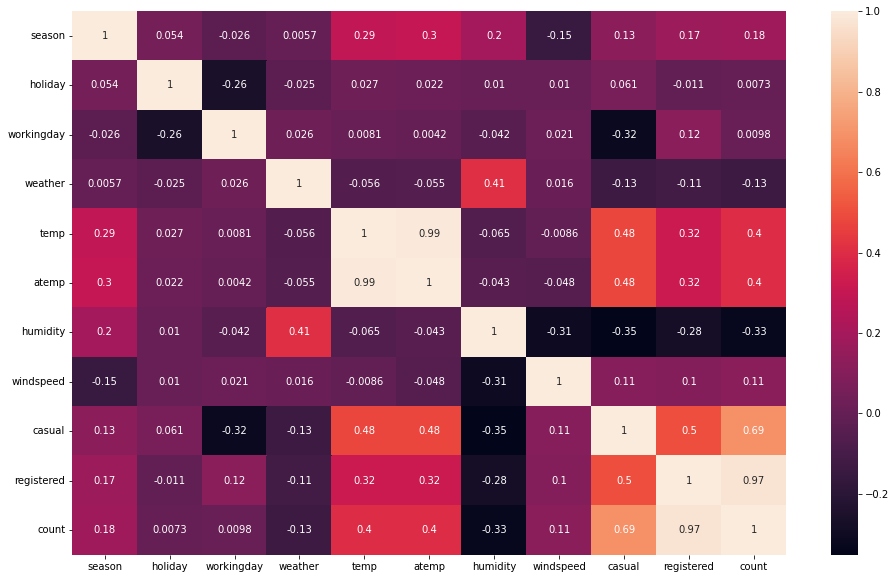


 The heatmap shows that temp, humidity, and windspeed are the most highly correlated. atemp is highly correlated with temp, so I will not include atemp.


In [3]:
#run heatmap of correlations to find which features are most correlated with count
plt.figure(figsize=(16,10)) 
sns.heatmap(train_df.corr(), annot=True) 
plt.show()
print('\n The heatmap shows that temp, humidity, and windspeed are the most highly correlated. atemp is highly correlated with temp, so I will not include atemp.')

In [4]:
# Create a new feature for hour of the day derived from datetime column
def get_hour(dt): 
  return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").time().hour  # strip hour from each datetime value 

train_df['hour_of_day'] = train_df['datetime'].map(get_hour) # map the function across every value in 'datetime' column
test_df['hour_of_day'] = test_df['datetime'].map(get_hour)

print('\n', test_df.head(), '\n')
print(train_df.head(), '\n')

# Create a new feature for month of the year
def get_month(dt):
  return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").month

train_df['month'] = train_df['datetime'].map(get_month)
print('\n',train_df.head())




               datetime  season  holiday  workingday  weather  temp  atemp  \
0  2011-01-17 00:00:00       1        1           0        2  8.20  9.850   
1  2011-01-17 01:00:00       1        1           0        2  8.20  9.850   
2  2011-01-17 02:00:00       1        1           0        2  7.38  8.335   
3  2011-01-17 03:00:00       1        1           0        2  7.38  9.090   
4  2011-01-17 04:00:00       1        1           0        2  7.38  9.850   

   humidity  windspeed  hour_of_day  
0        47    15.0013            0  
1        44    12.9980            1  
2        43    16.9979            2  
3        43    12.9980            3  
4        43     8.9981            4   

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.

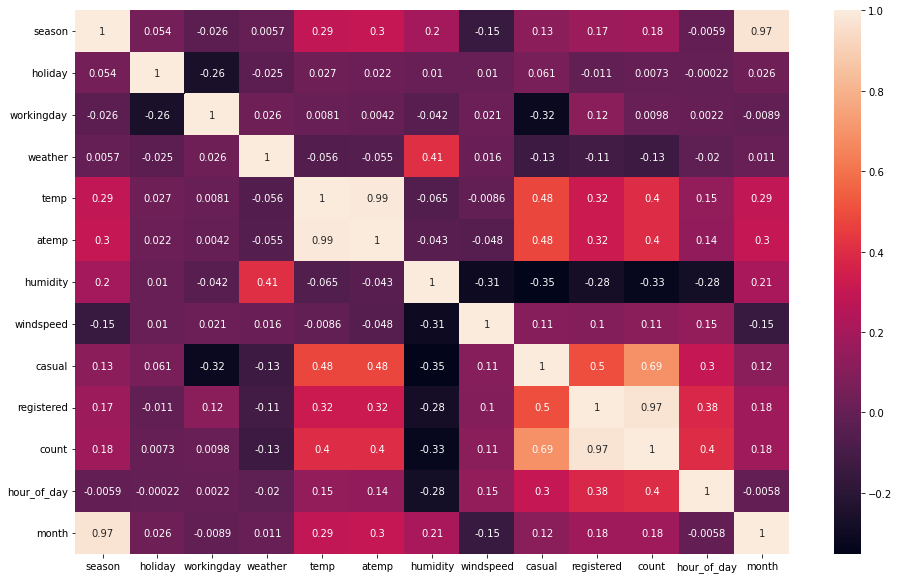


 Month turned out to only be moderately correlated, but hour of the day is now tied for most highly correlated with temp.


In [5]:
# re-run the heatmap to see if the new columns are more highly correlated than others
plt.figure(figsize=(16,10)) 
sns.heatmap(train_df.corr(), annot=True) 
plt.show()
print('\n Month turned out to only be moderately correlated, but hour of the day is now tied for most highly correlated with temp.')

hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


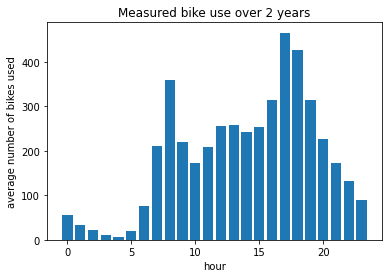


 Takeaways: The hours with the highest rentals are hours 05:00 pm-06:00pm & 08:00 am with very few bikes being rented between midnight and 05:00 am.


In [6]:
# visualize what hours have the highest and lowest counts
hours = np.unique(train_df['hour_of_day'])
print("hours:",hours)

hours_mean = {}
for h in hours:
    temp_df = train_df.loc[train_df['hour_of_day'] == h]
    hours_mean[h] = temp_df['count'].mean()

plt.bar(hours,[hours_mean[h] for h in hours])
plt.xlabel("hour")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")
plt.show()

print('\n Takeaways: The hours with the highest rentals are hours 05:00 pm-06:00pm & 08:00 am with very few bikes being rented between midnight and 05:00 am.')

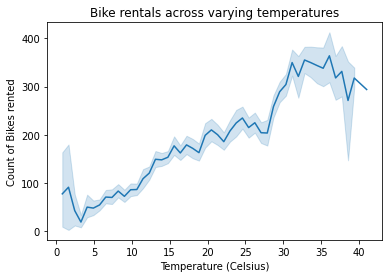


 Takeaways: as the temperature increases, the number of bikes rented also increases, but plateaus after a certain temperature as it begins to get too hot.


In [7]:
# visualize which temps have the highest and lowest counts
sns.lineplot(x = 'temp', y = 'count', data = train_df)
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Count of Bikes rented')
plt.title('Bike rentals across varying temperatures')
plt.show()

print('\n Takeaways: as the temperature increases, the number of bikes rented also increases, but plateaus after a certain temperature as it begins to get too hot.')

In [8]:
# pick your features
cols = ['hour_of_day', 'temp']

# pick your model (you should consider adjusting optional parameters too)
# reading in a few models we can pick from (there are many others)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# pick one by commenting/uncommenting
model = DecisionTreeRegressor()
#model = LinearRegression()
#model = KNeighborsRegressor(n_neighbors = 5)
#model = svm.LinearSVR()
#model = RandomForestRegressor(n_estimators = 1)

print("columns selected for later:",cols)
print(model) # to get an idea of parameters and confirm model chosen

columns selected for later: ['hour_of_day', 'temp']
DecisionTreeRegressor()


In [9]:
# this is a way of splitting training and testing by hand
# however, there are tools to do this automatically
# google "cross validation" for a better/more advanced strategy
#--------------------

n = len(train_df) # get number of rows in the training set
training_size = 0.75 # fraction of training data to split off for internal testing

# set up separate training and testing sets
# in this case using shuffled array indices
# there are many more ways to do this too
indices = np.array(range(n)) # makes an array of row indices in order
from numpy.random import shuffle
shuffle(indices)
split_point = int(n*training_size)
mytrain_i = indices[0:split_point]
mytest_i = indices[split_point:]

# now use those shuffled indices to separating training from test dataframes
new_train_df = train_df.iloc[mytrain_i]
new_test_df = train_df.iloc[mytest_i]

print("samples in the new training subset:",len(new_train_df))
print("samples in the new test subset:",len(new_test_df))

samples in the new training subset: 6880
samples in the new test subset: 2294


In [10]:
# fit the model to the training subset of original training data
model.fit(new_train_df[cols], new_train_df['count'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['count'],pred_count))
print("Decision Tree Regressor RMS error:",rms)

Decision Tree Regressor RMS error: 115.45563077369114


In [11]:
# pick one by commenting/uncommenting
#model = DecisionTreeRegressor()
model = LinearRegression()
#model = KNeighborsRegressor(n_neighbors = 5)
#model = svm.LinearSVR()
#model = RandomForestRegressor(n_estimators = 1)

print("columns selected for later:",cols)
print(model) # to get an idea of parameters and confirm model chosen

columns selected for later: ['hour_of_day', 'temp']
LinearRegression()


In [12]:
# fit the model to the training subset of original training data
model.fit(new_train_df[cols], new_train_df['count'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['count'],pred_count))
print("Linear Regression RMS error:",rms)

Linear Regression RMS error: 150.73843790391072


In [13]:
# pick one by commenting/uncommenting
#model = DecisionTreeRegressor()
#model = LinearRegression()
#model = KNeighborsRegressor(n_neighbors = 5)
#model = svm.LinearSVR()
model = RandomForestRegressor(n_estimators = 1)

print("columns selected for later:",cols)
print(model) # to get an idea of parameters and confirm model chosen

columns selected for later: ['hour_of_day', 'temp']
RandomForestRegressor(n_estimators=1)


In [14]:
# fit the model to the training subset of original training data
model.fit(new_train_df[cols], new_train_df['count'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['count'],pred_count))
print("Random Forest Regressor RMS error:",rms)

Random Forest Regressor RMS error: 123.53481259199383


In [15]:
# pick one by commenting/uncommenting
#model = DecisionTreeRegressor()
#model = LinearRegression()
model = KNeighborsRegressor(n_neighbors = 5)
#model = svm.LinearSVR()
#model = RandomForestRegressor(n_estimators = 1)

print("columns selected for later:",cols)
print(model) # to get an idea of parameters and confirm model chosen

columns selected for later: ['hour_of_day', 'temp']
KNeighborsRegressor()


In [16]:
# fit the model to the training subset of original training data
model.fit(new_train_df[cols], new_train_df['count'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['count'],pred_count))
print("KNN RMS error:",rms)

KNN RMS error: 119.22179750730082


Decision Tree Regressor remains lowest RMSE

In [17]:
# Create test file output
test_df.head()

model = DecisionTreeRegressor()
model.fit(train_df[cols], train_df['count'])
pred_count = model.predict(test_df[cols])
test_df['count'] = pred_count
test_df = test_df[['datetime','count']].to_csv('my_prediction.csv', 
    index=False, header=True)
print("Prediction complete. Saved as my_prediction.csv")
print(test_df)

Prediction complete. Saved as my_prediction.csv
None


 Question 2 (20 points) Build a regession model to predict the change in price of the stock overtime. It can either be linear regression or non-linear regression. You can download the dataset from here: https://github.com/suthapalliuday/INFO5502-Summer2022/blob/main/datasets/portfolio_data.csv. The implementation of the LSTM on this same dataset was posted here as an reference: https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook

 ### Your code

In [18]:
### You code here:

# download the data set to be analyzed
url = "https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/portfolio_data.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

df.head()



,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


In [23]:
# pick your features
cols = ['AMZN', 'DPZ', 'NFLX']

# pick your model (you should consider adjusting optional parameters too)
# reading in a few models we can pick from (there are many others)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# define model
model = LinearRegression()

print("columns selected for later:",cols)
print(model) # to get an idea of parameters and confirm model chosen

columns selected for later: ['AMZN', 'DPZ', 'NFLX']
LinearRegression()


In [24]:
# this is a way of splitting training and testing by hand
# however, there are tools to do this automatically
# google "cross validation" for a better/more advanced strategy
#--------------------

n = len(df) # get number of rows in the training set
training_size = 0.75 # fraction of training data to split off for internal testing

# set up separate training and testing sets
# in this case using shuffled array indices
# there are many more ways to do this too
indices = np.array(range(n)) # makes an array of row indices in order
from numpy.random import shuffle
shuffle(indices)
split_point = int(n*training_size)
mytrain_i = indices[0:split_point]
mytest_i = indices[split_point:]

# now use those shuffled indices to separating training from test dataframes
new_train_df = df.iloc[mytrain_i]
new_test_df = df.iloc[mytest_i]

print("samples in the new training subset:",len(new_train_df))
print("samples in the new test subset:",len(new_test_df))



samples in the new training subset: 1140
samples in the new test subset: 380


In [27]:
# fit the model to the training subset of original training data
model.fit(new_train_df[cols], new_train_df['BTC'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['BTC'],pred_count))
print("Linear regression model RMSE:",rms)

Linear regression model RMSE: 2068.319185919216


In [28]:
# fit the model to the training subset of original training data
model = DecisionTreeRegressor()
model.fit(new_train_df[cols], new_train_df['BTC'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['BTC'],pred_count))
print("Decision Tree Regressor RMSE:",rms)

Decision Tree Regressor RMSE: 812.4480022515589


In [29]:
# fit the model to the training subset of original training data
model = KNeighborsRegressor(n_neighbors = 5)
model.fit(new_train_df[cols], new_train_df['BTC'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['BTC'],pred_count))
print("Decision Tree Regressor RMSE:",rms)

Decision Tree Regressor RMSE: 688.9997203835525


In [30]:
# fit the model to the training subset of original training data
model = RandomForestRegressor(n_estimators = 1)
model.fit(new_train_df[cols], new_train_df['BTC'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['BTC'],pred_count))
print("Random Forest Regressor RMSE:",rms)

Random Forest Regressor RMSE: 646.852237472631
